In [18]:
# === Imports ===
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import RobustScaler
import joblib
import yaml

# === Display & paths ===
sns.set_theme()
pd.set_option("display.max_columns", 120)

REPORTS_DIR = Path("reports")
FIGS_DIR = REPORTS_DIR / "figs"
MODELS_DIR = Path("models")
CONFIG_DIR = Path("config")

for d in [REPORTS_DIR, FIGS_DIR, MODELS_DIR, CONFIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# === Training config ===
RANDOM_STATE = 42
TEST_SIZE = 0.30
TARGET_CANDIDATES = ["label","Label"," Label","class","Class","attack","Attack","target","Target"]

# Optional scaling (RF doesn’t need scaling, but RobustScaler helps if features are very skewed)
APPLY_SCALING = False
ROBUST_SCALER_QR = (5.0, 95.0)  # quantile range for RobustScaler


In [11]:
#Load cleaned dataset
DATA_PATH = "../data/cleaned_cicddos2019_sample.csv"  # Go up one directory from notebooks to project root
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)

(581613, 88)


,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,-0.818780,-0.022612,-0.084344,-0.599931,0.010236,1.461530,0.069283,-1.737906,-0.018015,0.223670,-0.027334,3.439851,-0.012137,-0.950231,-0.941322,-0.948191,-0.043051,-0.030924,-0.039058,-0.033481,-0.028521,-1.343403,-2.295521,-0.019654,-0.024833,-0.024820,-0.004979,-0.017067,-0.022439,-0.024722,-0.023853,-0.004920,-0.023911,-0.019751,-0.021141,-0.021584,-0.030684,-0.027795,0.0,0.0,0.0,0.062187,0.002622,-2.295272,-0.008046,-0.941295,-0.950482,-0.948911,-0.042613,-0.023269,0.0,-0.008894,-0.027795,0.0,-0.037391,-0.05731,-0.044394,0.0,-0.05716,-1.202411,-0.948191,-0.033481,0.062187,0.0,0.0,0.0,0.0,0.0,0.0,0.223670,3.439851,-0.027334,-0.012137,-0.035548,-0.025175,3.494683,0.275565,-0.011704,-0.004716,-0.008445,-0.011364,-0.024276,-0.008069,-0.024366,-0.023907,-0.014272,0.081031,-1.327339
1,-0.818706,-0.569552,10.814726,-0.599931,-14.299329,1.461530,0.069283,-1.737900,-0.029238,-0.013848,-0.027334,-0.231981,-0.012137,-0.950231,-0.941322,-0.948191,-0.043051,-0.030924,-0.039058,-0.033481,-0.028521,-0.953329,-0.843019,-0.021189,-0.026297,-0.027713,-0.004971,-0.028399,-0.023823,-0.026001,-0.026781,-0.004911,-0.023911,-0.019751,-0.021141,-0.021584,-0.030684,-0.027795,0.0,0.0,0.0,0.062187,0.002622,-0.842878,-0.008046,-0.941295,-0.950482,-0.948911,-0.042613,-0.023269,0.0,-0.008894,-0.027795,0.0,-0.037391,-0.05731,-0.044394,0.0,-0.05716,-0.937525,-0.948191,-0.033481,0.062187,0.0,0.0,0.0,0.0,0.0,0.0,-0.013848,-0.231981,-0.027334,-0.012137,-0.035548,-0.025175,-0.140838,0.275565,-0.011704,-0.004716,-0.008445,-0.011364,-0.024276,-0.008069,-0.024366,-0.023907,-0.014272,-12.340912,-1.327339
2,-0.800518,-0.037917,-0.084344,-0.599931,0.010236,0.719963,0.069283,-1.737894,-0.010061,0.481189,-0.027334,7.420890,-0.012137,-0.950231,-0.941322,-0.948191,-0.043051,-0.030924,-0.039058,-0.033481,-0.028521,-1.343127,-2.294493,-0.019926,-0.024608,-0.023353,-0.004979,-0.009037,-0.022684,-0.024526,-0.022369,-0.004920,-0.023911,-0.019751,-0.021141,-0.021584,-0.030684,-0.027795,0.0,0.0,0.0,0.062187,0.002622,-2.294243,-0.008046,-0.941295,-0.950482,-0.948911,-0.042613,-0.023269,0.0,-0.008894,-0.027795,0.0,-0.037391,-0.05731,-0.044394,0.0,-0.05716,-1.205283,-0.948191,-0.033481,0.062187,0.0,0.0,0.0,0.0,0.0,0.0,0.481189,7.420890,-0.027334,-0.012137,-0.035548,-0.025175,7.436353,0.275565,-0.011704,-0.004716,-0.008445,-0.011364,-0.024276,-0.008069,-0.024366,-0.023907,-0.014272,0.081031,-1.327339


In [ ]:
#Identify target column and Train Test Split
# Use the correct target column name found in the dataset
target_col = " Label"  # The actual column name with leading space
print("Target column:", target_col)

X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Let's check what classes we have in the target variable
print("Unique values in target column:", sorted(y.unique()))
print("Value counts:")
print(y.value_counts().sort_index())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

Target column:  Label


((407129, 87), (174484, 87))

In [20]:
# Coerce to numeric, set bad values to NaN
X_train = X_train.apply(pd.to_numeric, errors="coerce")
X_test  = X_test.apply(pd.to_numeric, errors="coerce")

# Replace ±inf with NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test  = X_test.replace([np.inf, -np.inf], np.nan)

# Median imputation (robust to skew)
imp = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test  = pd.DataFrame(imp.transform(X_test),   columns=X.columns, index=X_test.index)

# Optional: Robust scaling (RF doesn’t require it, but safe if you want)
if APPLY_SCALING:
    scaler = RobustScaler(quantile_range=ROBUST_SCALER_QR)
    num_cols = X_train.columns  # all are numeric now
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols]  = scaler.transform(X_test[num_cols])

print("Prepared shapes:", X_train.shape, X_test.shape)

Prepared shapes: (407129, 87) (174484, 87)


In [21]:
#Train Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",   # helpful for class imbalance
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Model Performance → Acc: 0.9999 | Prec: 0.9999 | Rec: 0.9999 | F1: 0.9999

Classification report:
               precision    recall  f1-score   support

          -2       1.00      1.00      1.00       896
          -1       1.00      1.00      1.00     42613
           0       1.00      1.00      1.00     87821
           1       1.00      1.00      1.00     43154

    accuracy                           1.00    174484
   macro avg       1.00      1.00      1.00    174484
weighted avg       1.00      1.00      1.00    174484



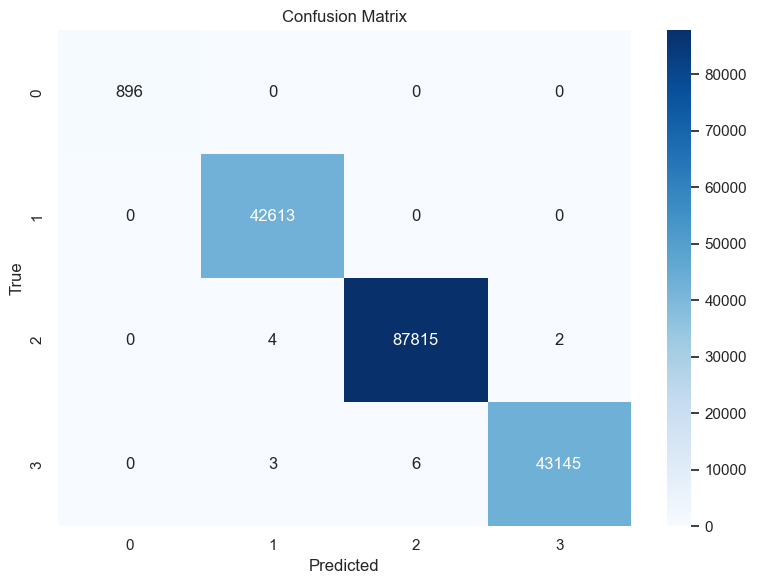

In [23]:
#Evaluate model performance
# For multiclass classification, use predict() instead of threshold-based predictions
pred_test = rf.predict(X_test)
proba_test = rf.predict_proba(X_test)

acc = accuracy_score(y_test, pred_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred_test, average="weighted", zero_division=0)

print(f"Model Performance → Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")
print("\nClassification report:\n", classification_report(y_test, pred_test, zero_division=0))

cm = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cbar=True, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout()
plt.savefig(FIGS_DIR / "confusion_matrix.png", dpi=120)
plt.show()

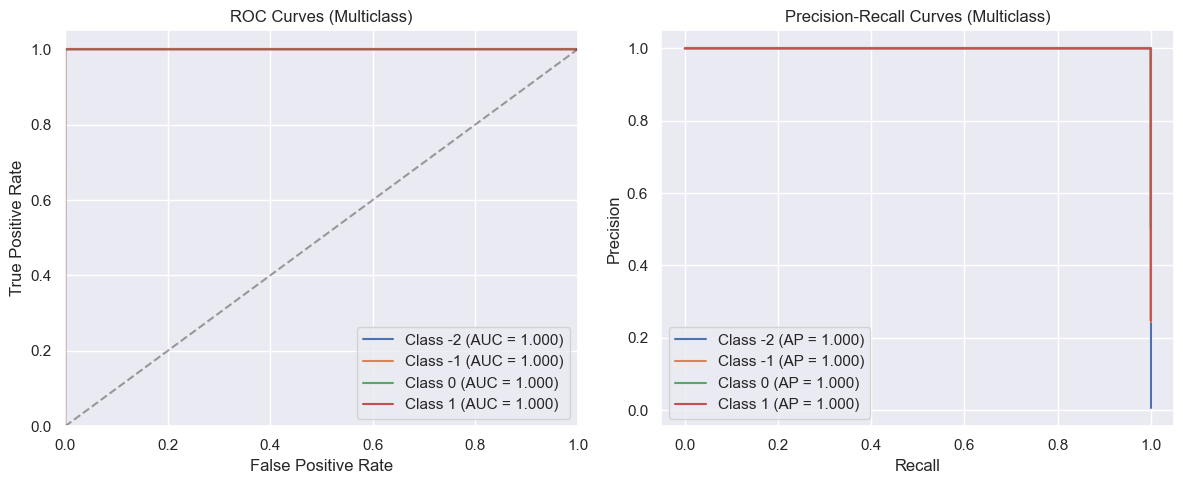

Macro-averaged AUC: 1.000
Micro-averaged AUC: 1.000


In [25]:
#Multiclass ROC and PR Curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Get unique classes
classes = np.unique(y_test)
n_classes = len(classes)

# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(12, 5))

# ROC Curves
plt.subplot(1, 2, 1)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], proba_test[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Multiclass)')
plt.legend()

# Precision-Recall Curves
plt.subplot(1, 2, 2)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], proba_test[:, i])
    ap = average_precision_score(y_test_bin[:, i], proba_test[:, i])
    plt.plot(recall, precision, label=f'Class {classes[i]} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Multiclass)')
plt.legend()

plt.tight_layout()
plt.savefig(FIGS_DIR / "multiclass_roc_pr_curves.png", dpi=120)
plt.show()

# Calculate overall metrics
from sklearn.metrics import roc_auc_score
macro_auc = roc_auc_score(y_test_bin, proba_test, average='macro', multi_class='ovr')
micro_auc = roc_auc_score(y_test_bin, proba_test, average='micro', multi_class='ovr')

print(f"Macro-averaged AUC: {macro_auc:.3f}")
print(f"Micro-averaged AUC: {micro_auc:.3f}")

In [26]:
#Model Performance Summary
# For multiclass classification, we use the predictions directly (no threshold needed)
print("=== Model Performance Summary ===")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted Precision: {prec:.4f}")
print(f"Weighted Recall: {rec:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

# Detailed per-class performance
print("\n=== Per-Class Performance ===")
per_class_metrics = precision_recall_fscore_support(y_test, pred_test, average=None, zero_division=0)
classes = np.unique(y_test)

for i, cls in enumerate(classes):
    print(f"Class {cls}: Precision={per_class_metrics[0][i]:.3f}, Recall={per_class_metrics[1][i]:.3f}, F1={per_class_metrics[2][i]:.3f}")

# Feature importance analysis
print("\n=== Top 10 Most Important Features ===")
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(10))

=== Model Performance Summary ===
Accuracy: 0.9999
Weighted Precision: 0.9999
Weighted Recall: 0.9999
Weighted F1-score: 0.9999

=== Per-Class Performance ===
Class -2: Precision=1.000, Recall=1.000, F1=1.000
Class -1: Precision=1.000, Recall=1.000, F1=1.000
Class 0: Precision=1.000, Recall=1.000, F1=1.000
Class 1: Precision=1.000, Recall=1.000, F1=1.000

=== Top 10 Most Important Features ===
 Timestamp                     0.303232
Flow ID                        0.067855
Total Length of Fwd Packets    0.050044
 Fwd Packet Length Min         0.045918
 Source Port                   0.044958
Unnamed: 0                     0.044568
 Average Packet Size           0.040600
 Fwd Packet Length Mean        0.039693
 Min Packet Length             0.039058
 Avg Fwd Segment Size          0.038988
dtype: float64


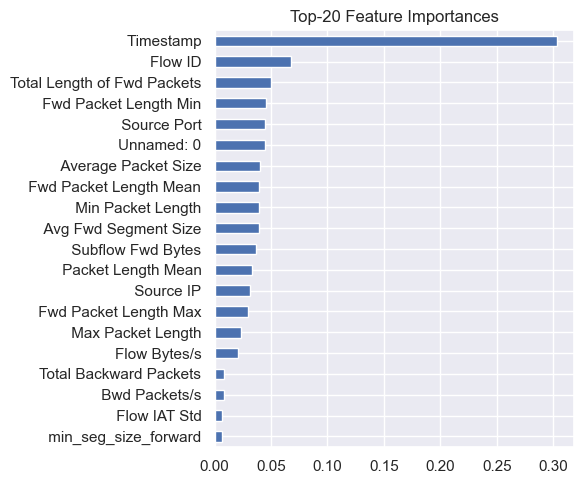

 Timestamp                     0.303232
Flow ID                        0.067855
Total Length of Fwd Packets    0.050044
 Fwd Packet Length Min         0.045918
 Source Port                   0.044958
Unnamed: 0                     0.044568
 Average Packet Size           0.040600
 Fwd Packet Length Mean        0.039693
 Min Packet Length             0.039058
 Avg Fwd Segment Size          0.038988
dtype: float64

In [27]:
#Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top20 = importances.head(20)

plt.figure(figsize=(6,5))
top20[::-1].plot(kind="barh")
plt.title("Top-20 Feature Importances")
plt.tight_layout()
plt.savefig(FIGS_DIR / "feature_importance_top20.png", dpi=120)
plt.show()

top20.to_csv(REPORTS_DIR / "feature_importance_top20.csv")
importances.head(10)


In [29]:
#Save Artifacts (local only; keep out of Git)
# Save model
model_path = MODELS_DIR / "rf_multiclass.pkl"
joblib.dump(rf, model_path)

# Save config for serving
config = {
    "model_path": str(model_path),
    "feature_columns": list(X.columns),
    "target": target_col,
    "classes": [int(cls) for cls in np.unique(y)],  # Convert numpy types to native Python int
    "notes": "RandomForest (multiclass), class_weight=balanced, median-imputed, "
             + ("robust-scaled" if APPLY_SCALING else "no-scaling")
}
with open(CONFIG_DIR / "model_config.yaml", "w") as f:
    yaml.safe_dump(config, f)

# Save compact metrics
metrics = {
    "accuracy": float(acc),
    "weighted_precision": float(prec),
    "weighted_recall": float(rec),
    "weighted_f1": float(f1),
    "macro_auc": float(macro_auc),
    "micro_auc": float(micro_auc),
    "n_classes": int(n_classes)
}
with open(REPORTS_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved:")
print("-", model_path)
print("-", CONFIG_DIR / "model_config.yaml")
print("-", REPORTS_DIR / "metrics.json")
print("Figures in:", FIGS_DIR)

Saved:
- models\rf_multiclass.pkl
- config\model_config.yaml
- reports\metrics.json
Figures in: reports\figs


In [31]:
#Test Model Predictions
# Take 5 rows from X_test and show predictions
sample = X_test.iloc[:5].copy()
predictions = rf.predict(sample)
probabilities = rf.predict_proba(sample)

# Get the class names
classes = np.unique(y)
class_names = [f"Class_{cls}" for cls in classes]

# Create a results dataframe
results_df = pd.DataFrame({
    "Predicted_Class": predictions,
    "True_Class": y_test.iloc[:5].values
})

# Add probability scores for each class
for i, class_name in enumerate(class_names):
    results_df[f"Prob_{class_name}"] = probabilities[:, i]

print("Sample Predictions:")
print(results_df)

# Show which class has the highest probability for each sample
print("\nPrediction Summary:")
for idx, row in results_df.iterrows():
    pred_class = row["Predicted_Class"]
    true_class = row["True_Class"]
    max_prob = probabilities[idx].max()
    print(f"Sample {idx}: Predicted={pred_class}, True={true_class}, Max_Probability={max_prob:.3f}")

Sample Predictions:
   Predicted_Class  True_Class  Prob_Class_-2  Prob_Class_-1  Prob_Class_0  \
0                1           1            0.0           0.00      0.013333   
1               -1          -1            0.0           1.00      0.000000   
2                0           0            0.0           0.01      0.990000   
3                0           0            0.0           0.00      1.000000   
4                0           0            0.0           0.00      1.000000   

   Prob_Class_1  
0      0.986667  
1      0.000000  
2      0.000000  
3      0.000000  
4      0.000000  

Prediction Summary:
Sample 0: Predicted=1.0, True=1.0, Max_Probability=0.987
Sample 1: Predicted=-1.0, True=-1.0, Max_Probability=1.000
Sample 2: Predicted=0.0, True=0.0, Max_Probability=0.990
Sample 3: Predicted=0.0, True=0.0, Max_Probability=1.000
Sample 4: Predicted=0.0, True=0.0, Max_Probability=1.000
